# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

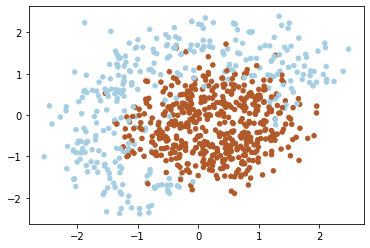

In [4]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [5]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """

    # ваш код здесь
    X_expanded = X.copy()
    X_columns_count = X.shape[1]
    for i in range(X_columns_count):
      for j in range(i+1):
        X_expanded = np.append(X_expanded, np.expand_dims(X[:,i]*X[:,j], axis=1), axis=1)
    X_expanded = np.append(X_expanded, np.ones((X_expanded.shape[0],1)), axis=1)
    return X_expanded

In [6]:
X_ext = expand(X)

### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [7]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """

    # ваш код здесь
    z = (X*w).sum(axis=1)
    p = 1/(1+np.exp(-z))
    return p

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [8]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """

    # ваш код здесь
    predictions = probability(X,w)
    L = -(y*np.log(predictions) + (1-y)*np.log((1-predictions))).sum()/len(y)
    return L

In [9]:
compute_loss(X_ext, y, [1,1,1,1,1,1])

2.059842818509439

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [10]:
def compute_grad(X, y, w):
    """
    Находит значение градиента.
    """

    # ваш код здесь
    p = probability(X,w)
    der = 2*(p-y)
    g = np.dot(X.T, der)
    return g

compute_grad(X_ext, y, [0,0,0,0,0,1])

array([-275.82054956,  250.21727261,  654.09643454,  289.59727342,
        654.94155353,  183.7087719 ])

Функция ниже предназначена для визуализации процесса обучения. 

In [11]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

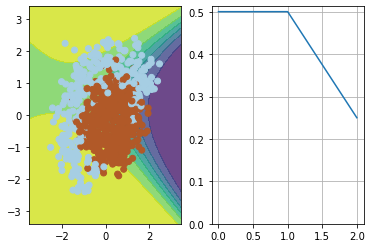

In [12]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



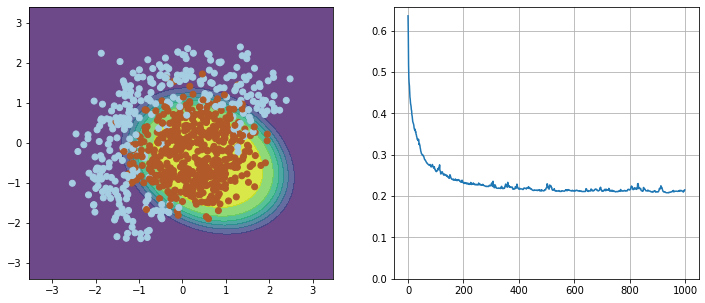

<Figure size 432x288 with 0 Axes>

In [13]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 

n_iter = 1000
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    # Ваш код здесь 
    selected_rows = np.random.choice(np.arange(X.shape[0]), batch_size)
    X_selected = X_ext[selected_rows]
    y_selected = y[selected_rows]

    grad = compute_grad(X_selected, y_selected, w)
    w_new = w - eta/batch_size * grad
    w = w_new

    l = compute_loss(X_ext, y, w)
    loss[i] = l
    


visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


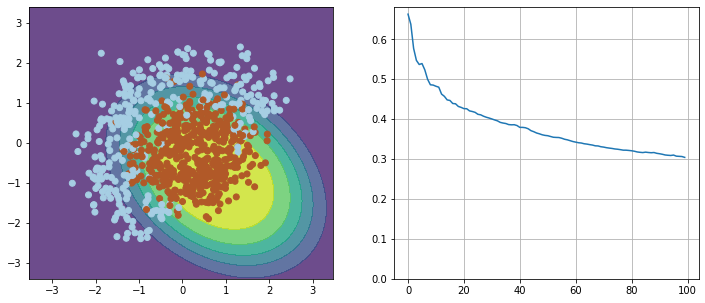

<Figure size 432x288 with 0 Axes>

In [18]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    # Ваш код здесь 
    selected_rows = np.random.choice(np.arange(X.shape[0]), batch_size)
    X_selected = X_ext[selected_rows]
    y_selected = y[selected_rows]

    grad = compute_grad(X_selected, y_selected, w)
    nu_new = alpha*nu + eta/batch_size*grad
    w_new = w - nu_new
    w = w_new

    l = compute_loss(X_ext, y, w)
    loss[i] = l

visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

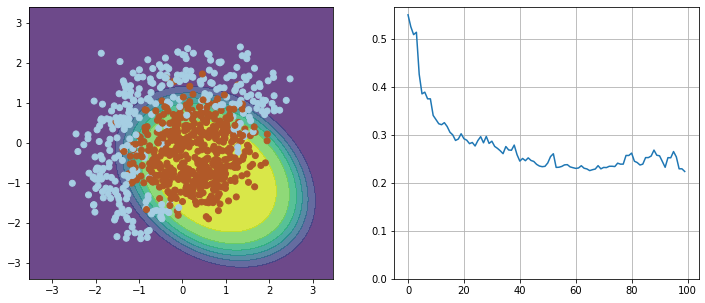

<Figure size 432x288 with 0 Axes>

In [19]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    # Ваш код здесь
    selected_rows = np.random.choice(np.arange(X.shape[0]), batch_size)
    X_selected = X_ext[selected_rows]
    y_selected = y[selected_rows]
    grad = compute_grad(X_selected, y_selected, w)

    g2_new = alpha * g2 + (1-alpha) * grad * grad
    g2 = g2_new

    w_new = w - (eta/(np.sqrt(g2+eps))) * grad
    w = w_new

    l = compute_loss(X_ext, y, w)
    loss[i] = l 

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть дополнительные баллы за реализацию каждой новой адекватной вариации. 

In [ ]:
# ADAM

In [ ]:
# Ваш код здесь 